### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest

pd.set_option('display.width', None)
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Functions

In [2]:
def drop_by_index(X,indexes):
    """
    helper function to drop rows of dataframe and return new dataframe without those rows with indexes resetted
    """
    X = X.drop(indexes)
    X = X.reset_index().drop(columns="index")
    return(X)

def dataSetting(dropCol,FILE_FOLDER = "C:\\SMU_v2\\"):
    '''
    function to read the pkl from from datasource
        1. Remove dx_date that is NULL.
        2. Drop all rows where crucial fields for X_features are NULL.
        3. Convert Date columns into datetime format
        4. Derive OS, CSS, DFS days based on dx_date
        5. Create status column to indicate if the patient is dead or alive base on if death_age exists
    '''
    df = pd.read_pickle(FILE_FOLDER + "clinical_output.pkl").reset_index().drop(columns="index")
    to_drop = df[df['dx_date']=="NA"].index
    df = drop_by_index(df,to_drop)

    df.drop(columns=dropCol,inplace = True)

    # drop all rows where dates are null
    df.dropna(axis=0,\
                    subset=['Date_for_DFS','Date_for_OS','Date_for_CSS','dx_date','Age_@_Dx'],\
                    inplace=True)
    
    # convert all datetime in dataframe into dateime format for processing
    df["Date_for_DFS"] = pd.to_datetime(df["Date_for_DFS"])
    df["Date_for_OS"] = pd.to_datetime(df["Date_for_OS"])
    df["Date_for_CSS"] = pd.to_datetime(df["Date_for_CSS"])
    df["dx_date"] = pd.to_datetime(df["dx_date"])
    df['last_seen']= pd.to_datetime(df["dx_date"])
    df['dob']= pd.to_datetime(df["dx_date"])

    # calculate in days
    df["DFS_days"] = (df["Date_for_DFS"] - df['dx_date'] )/np.timedelta64(1, 'D')
    df["OS_days"] = (df["Date_for_OS"] - df['dx_date'] )/np.timedelta64(1, 'D')
    df["CSS_days"] = (df["Date_for_CSS"] - df['dx_date'] )/np.timedelta64(1, 'D')

    # alive or dead
    df['status'] = np.where(df['Count_as_OS'] == "dead", False, True)
    
#     # age
#     df.loc[df['Age_@_Dx'].isnull() ,'Age_@_Dx'] = round((df['dx_date'] - df['dob']).dt.days/365.25,1)
    
    return df

def ComputeYears(df, Year_list):
    '''
    Create a list to contain df for different years of survival
    The df will filter those patient that has deceased or days of survival longer than the defined years.
    '''

    df_dict = {}

    for i in Year_list:
        tmp = {}
        for x in list(["DFS", "CSS", "OS"]):
            df['{}_{}_years'.format(x, i)] = np.where(
                                                      np.logical_or(df['death_age'] > 0,\
                                                      df['{}_days'.format(x)]/(365.25*i) >= i),\
                                                      True,False)
            tmp[x] = df[df['{}_{}_years'.format(x, i)] == True]
        df_dict['{}_years'.format(i)] = tmp
    return df_dict

def dropSubGroup(df,colToDropSubGroup,subgroups, notDropSubgroups):
    '''
    drop patient records that contains T,N.M subgroups ('a','b','c')
    
    notDropSubGroups is a list of values that we want to be cautious and not drop during processing
    '''
    index_list = set()
    index_not_drop = set()
    for col in colToDropSubGroup:
        for subgroup in subgroups:
            index_list.update(list(df[df['{}'.format(col)].str.contains(subgroup)].index))
        for notDropgroup in notDropSubgroups:
            index_not_drop.update(list(df[df['{}'.format(col)].str.contains(notDropgroup)].index))
    
    # in-depth filtering
    tmp = set()
    for i in index_not_drop:
        chance = 1
        for col in colToDropSubGroup:
            for subgroup in subgroups: 
                for notDropgroup in notDropSubgroups:
                    if subgroup in df[col][i] and not (notDropgroup in df[col][i]):
                        chance = 0
        if chance == 1:
            tmp.add(i)
    
    cfm_index_list = list(index_list.difference(tmp))
    
    return drop_by_index(df,cfm_index_list)

def train_test(X, Y, test_size = 0.33, random_state = 42):
    '''
    Splitting the dataset into the Training set and Test set
    '''
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,  test_size=test_size, random_state=random_state)
    
    return X_train, X_test, Y_train, Y_test

def Cox(X_train,Y_train,alpha = 1e-2, verbose = 0):
        
    # since features are highly corelated, reducing alpha values to smaller values allows the learning
    model = CoxPHSurvivalAnalysis(alpha = alpha, verbose = verbose)
    model.fit(X_train, Y_train)

    return model

def fit_and_score_features(X, y):
    '''
    Based on the Cox model, rank the scores of each feature to understand which X features plays the key role in
    modelling
    '''
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis(alpha = 1e-4)
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

def plotGraph(df, YEAR, STYPE, UNITS = 0, ):
    '''
    function to plot the graph
    UNITS: {0: days, 1: years}
    '''
    if UNITS == 1:
        unit = "Years"
    else:
        unit = "Days"
        
    time, survival_prob = kaplan_meier_estimator(df['{}_years'.format(YEAR)][STYPE]['status'], 
                                                 df['{}_years'.format(YEAR)][STYPE]['{}_days'.format(STYPE)])
    
    if UNITS == 1:
        time = time/365.25
    plt.step(time, survival_prob, where="post")
    
    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$ ({})".format(unit))
    plt.title("{} Years Survival Rate for {}".format(YEAR,STYPE))
    plt.grid(True)
    return plt

def FeaturesPriority(df,x_features,y_features):
    # change unknown to nx
    df['cNstage'].replace(to_replace ="unknown", 
                                       value ="nx", inplace = True) 
    df['nstage'].replace(to_replace ="unknown", 
                                   value ="nx", inplace = True) 

    # to prevent changing of the orginial df
    working_df = df.copy()
    
    t_score = {
                "t4d": 1, 't4c':2,'t4b':3,'t4a':4,'t4':5,\
                't3': 6,'t2':7,\
                't1c': 8,'t1b':9,'t1a': 10,'t1mic':11,'t1': 12,\
                't0':13,'tis':14,'tx': 15
               }
    
    m_score = {'m1a': 1, 'm1': 2, 'm0': 3, 'mx': 4}
    
    n_score = {
                'n3c':1,'n3b':2,'n3a':3,'n3':4,\
                'n2b':5,'n2a':6,'n2':7,\
                'n1c':8,'n1b':9,'n1a':10,'n1mic':11,'n1':12,\
                'n0 (i+)':13,'n0':14,'nx':15
                }
    
    working_df['t_1'] = working_df['tstage'].map(t_score)
    working_df['t_2'] = working_df['c_tstage'].map(t_score)
    
    working_df['m_1'] = working_df['Mstage'].map(m_score)
    working_df['m_2'] = working_df['cMstage'].map(m_score)
    
    working_df['n_1'] = working_df['cNstage'].map(n_score)
    working_df['n_2'] = working_df['nstage'].map(n_score)
    
    # convert as new columns are categorical
    for x in ['t_1','t_2','m_1','m_2','n_1','n_2']:
        working_df.loc[:,x] = working_df[x].astype("int16")
    
    working_df.loc[working_df['t_1'] > working_df['t_2'] ,'tstage_tmp'] = working_df['c_tstage']
    working_df.loc[working_df['t_1'] <= working_df['t_2'] ,'tstage_tmp'] = working_df['tstage']
    
    working_df.loc[working_df['m_1'] > working_df['m_2'] ,'Mstage_tmp'] = working_df['cMstage']
    working_df.loc[working_df['m_1'] <= working_df['m_2'] ,'Mstage_tmp'] = working_df['Mstage']
    
    working_df.loc[working_df['n_1'] > working_df['n_2'] ,'nstage_tmp'] = working_df['nstage']
    working_df.loc[working_df['n_1'] <= working_df['n_2'] ,'nstage_tmp'] = working_df['cNstage']
    
    working_df.drop(columns = ["Mstage",'nstage','tstage'], inplace = True)
    working_df.rename(columns={'Mstage_tmp':'Mstage', 'nstage_tmp':'nstage','tstage_tmp':'tstage'}, inplace=True)
    
    working_df.loc[:,'tstage'] = working_df['tstage'].astype("category")
    working_df.loc[:,'nstage'] = working_df['nstage'].astype("category")
    working_df.loc[:,'Mstage'] = working_df['Mstage'].astype("category")
    
    x_features = [e for e in x_features if e not in ['c_tstage','cNstage','cMstage']]
    return working_df[x_features+y_features]

def settingXY(df, X_features, Y_features, OHE_LOCATION = "C:\\SMU_v2\\OHE\\", name=""):
    '''
    This function returns the X and Y features need for model training
        - The function also generates one pkl that contains the One Hot Encoder for new raw data 
    
    X_features = features to use for X
    Y_features = features to use for Y 
    YEAR = years of patient record interested
    SYTPE = survival type (OS, DFS, CSS)
    OHE_LOCATION = location to store the pkl file
    '''
    import pickle

    X = df[X_features]
    Y = df[Y_features]

    # Save enconder so that we can OHE new data
    enc = OneHotEncoder()
    enc.fit(X)
    
    # OHE for probability
    X = enc.transform(X)
    with open(OHE_LOCATION + name + '_encoder.pickle', 'wb') as f:
        pickle.dump(enc, f) 
                  
    # convert Y to structured array
    s = Y.dtypes
    Y = np.array([tuple(x) for x in Y.values], dtype=list(zip(s.index, s)))
   
    return X, Y
def loadOHE(df,OHE_LOCATION = "C:\\SMU_v2\\OHE\\", name=""):
    '''
    load enconder to OHE new raw data for prediction
    '''
    import pickle
    with open(OHE_LOCATION + name + '_encoder.pickle', 'rb') as f:
        enc = pickle.load(f) 
    
    #type case object to category
    typeCastList = list(df.select_dtypes(include=[object]).columns)
    df[typeCastList] = df[typeCastList].astype("category")
    OHE_New_Data = enc.transform(df)
    
    return OHE_New_Data

def survivalTable(model,raw_data,interval):
    '''
    Calculate survival rate in years of interest
    Interval are in years.
    Raw_data must be in lowercase for values
    '''
    data = loadOHE(raw_data)
    surv = model.predict_survival_function(data)
    
    dic = {}
    
    for i, s in enumerate(surv):
        x = model.event_times_
        y = s
    for i in interval:
        result = np.where(x > (365.25*(i+1)))[0][0]
        dic[i] = y[result]
    return dic     ww     

### Data Processing

In [3]:
listToDrop = ['NRIC','dob','Has Bills?','Side','Hospital','KKH','NCCS','SGH','END_OF_ENTRY']

clinical = dataSetting(listToDrop)
print(clinical.shape)

(25947, 221)


In [4]:
# clinical['Size'].head(10)

### Data filtering

Data of our interest are 5 and 10 years, patient that are new (does not have sufficient records will disturb and mess up our accuracy level

In [5]:
year_list = list([1,5,10])

# only return data that has longer timeframe than the given interval
df_dict = ComputeYears(clinical,year_list)

# Display shape of data after filtering
for i in df_dict: 
    for s_type in df_dict[i]:
        print("Year: {}, survival category: {}, size: {}".format(i,s_type,df_dict[i][s_type].shape[0]))

Year: 1_years, survival category: DFS, size: 22961
Year: 1_years, survival category: CSS, size: 23435
Year: 1_years, survival category: OS, size: 23435
Year: 5_years, survival category: DFS, size: 6134
Year: 5_years, survival category: CSS, size: 6268
Year: 5_years, survival category: OS, size: 6268
Year: 10_years, survival category: DFS, size: 5902
Year: 10_years, survival category: CSS, size: 5902
Year: 10_years, survival category: OS, size: 5902


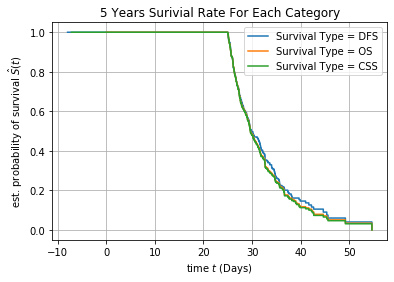

In [6]:
from sksurv.nonparametric import kaplan_meier_estimator

YEAR = 5
STYPE = "OS"
# k = plotGraph(df_dict,YEAR, STYPE, 0)

for survival in ("DFS", "OS", 'CSS'):
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        df_dict['{}_years'.format(YEAR)][survival]['status'],
        df_dict['{}_years'.format(YEAR)][survival]['{}_days'.format(survival)])
    
    plt.step(time_treatment/365.25, survival_prob_treatment, where="post",
             label="Survival Type = {}".format(survival))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (Days)")
plt.title("{} Years Surivial Rate For Each Category".format(YEAR))
plt.grid(True)
plt.legend(loc="best")

# plt.rcParams["figure.figsize"] = (30,10)

# for value in df_dict['{}_years'.format(YEAR)]['OS']["TNM_Stage"].unique():
#     mask = df_dict['{}_years'.format(YEAR)]['OS']["TNM_Stage"] == value
#     time_cell, survival_prob_cell = kaplan_meier_estimator(df_dict['{}_years'.format(YEAR)][STYPE]['status'][mask],
#                                                            df_dict['{}_years'.format(YEAR)][STYPE]['{}_days'.format(STYPE)][mask])
#     plt.step(time_cell, survival_prob_cell, where="post",
#              label= '{} (n = {})'.format(value, mask.sum()))

# plt.ylabel("est. probability of survival $\hat(t)$")
# plt.xlabel("time $t$")
# plt.grid(True)
# plt.legend(loc="best")

### Selecting population pool

Survival times are subject to right-censoring, therefore, we need to consider an individual's status
in addition to survival time. To be fully compatible with scikit-learn, Status and Survival_in_days
need to be stored as a structured array with the first field indicating whether the actual survival time
was observed or if was censored, and the second field denoting the observerd survival time,
which corresponds to the time of death (if Status == 'dead', $\delta = 1$) or the last time that
person was contacted (if Status == 'alive', $\delta = 0$).


In [7]:
%timeit
YEAR = 1
STYPE = "OS"

y_features = list(['status','OS_days'])

group_dict = { 
                "group 1": {
                             "stage": ['stage 4'],\
                             'wave': {
                                         "layer 1": ['Age_@_Dx', 'diff', 'ER', 'PR','Her2','Stage'],\
                                         "layer 2": ['Age_@_Dx', 'diff', 'ER', 'PR','Her2',\
                                                     'T (no subgroup)', 'N (no subgroup)'],\
                                         "layer 3": ['Age_@_Dx', 'diff', 'ER', 'PR','Her2', 'T', 'N'],\
                                         "layer 4": ['Age_@_Dx', 'diff', 'ER', 'PR','Her2', 'size_precise', 'nodespos']
                                     }
                           },\
                "group 2": {
                             'stage': ['dcis/lcis non-invasive'],\
                             'wave': {
                                         "layer 1": ['Age_@_Dx', 'diff', 'ER', 'PR','Her2','Size'],\
                                         "layer 2": ['Age_@_Dx', 'diff', 'ER', 'PR','Her2','size_precise']
                                     }
                           },\
                "group 3": {
                             "stage": ['stage 4','dcis/lcis non-invasive'],\
                             'wave': {
                                         "layer 1": ['Age_@_Dx', 'diff', 'ER', 'PR','Her2','Stage'],\
                                         "layer 2": ['Age_@_Dx', 'diff', 'ER', 'PR','Her2',\
                                                     'T (no subgroup)', 'N (no subgroup)', 'M (no subgroup)'],\
                                         "layer 3": ['Age_@_Dx', 'diff', 'ER', 'PR','Her2', 'T', 'N', 'M'],\
                                         "layer 4": ['Age_@_Dx', 'diff', 'ER', 'PR','Her2', 'size_precise',\
                                                     'nodespos','M']
                                     }
                           },
                }
         
def layeredData(df, group_dict,y_features, YEAR, STYPE):
    
    '''
        this function generates the dataframe required for specific groups we hope to analyze
        there are total 3 different groups but group 3 consist of multiple subgroups which leads a total of 5
        dataframe.
        Group 1: patient with stage 4 cancer
        Group 2: patient which unknown records or at initial diagnosis stage
        Group 3: make up of patient that does not belong to the groups above
    '''
    model_data_dict = {}
    TO_USE = df['{}_years'.format(YEAR)][STYPE]
    
    print("Overall initial size: {} \n".format(TO_USE.shape[0]))
        
    for key,value in group_dict.items():
        TO_USE_COPY = TO_USE.copy()

        tmp = {}
        
        waves = value['wave']
    
        if key != "group 3":
            # for group 1 and group 2 select rows that contains either stage 4/non invasive in Stage
            TO_USE_COPY = TO_USE_COPY.loc[TO_USE_COPY['Stage'] == group_dict[key]['stage'][0]]
        else:
            # for group 3 do not select rows that contains either stage 4 or non invasive in c_Staging or p_Staging
            stage = np.logical_and(TO_USE_COPY['Stage'] != group_dict[key]['stage'][0],\
                                    TO_USE_COPY['Stage'] != group_dict[key]['stage'][1])
            
            TO_USE_COPY = TO_USE_COPY.loc[stage]
            
        print("{} data size: {}".format(key,len(TO_USE_COPY)))
        
        for wave in waves:
            TO_USE_COPY2 = TO_USE_COPY.copy()
            TO_USE_COPY2 = TO_USE_COPY2[waves[wave] + y_features]
            
            len_before = len(TO_USE_COPY2)
            print("\t{} data size before dropping nan: {}".format(wave,len_before))
            
            TO_USE_COPY2.dropna(axis=0,subset=waves[wave]+ y_features, inplace=True)
            TO_USE_COPY2.reset_index(drop=True)

            len_after = len(TO_USE_COPY2)
            print("\t\t after dropping nan: {}".format(len_after))
            
            for i in waves[wave]:
                if not (i in ['nodespos','Age_@_Dx','size_precise']):
                    TO_USE_COPY2.loc[:,i] = TO_USE_COPY2[i].astype("category")
                else:
                    TO_USE_COPY2.loc[:,i] = TO_USE_COPY2[i].astype("float32")
            
            X, Y = settingXY(TO_USE_COPY2, waves[wave], y_features,name= "{}_{}".format(key,wave))   

            tmp[wave] = {
                            "X": X,\
                            "Y":Y      
                        }    
    
        model_data_dict[key] = tmp
    return model_data_dict
model_data_dict = layeredData(df_dict, group_dict,y_features,YEAR, STYPE)

Overall initial size: 23435 

group 1 data size: 2029
	layer 1 data size before dropping nan: 2029
		 after dropping nan: 2029
	layer 2 data size before dropping nan: 2029
		 after dropping nan: 2029
	layer 3 data size before dropping nan: 2029
		 after dropping nan: 2029
	layer 4 data size before dropping nan: 2029
		 after dropping nan: 457
group 2 data size: 2452
	layer 1 data size before dropping nan: 2452
		 after dropping nan: 1961
	layer 2 data size before dropping nan: 2452
		 after dropping nan: 1990
group 3 data size: 18954
	layer 1 data size before dropping nan: 18954
		 after dropping nan: 18954
	layer 2 data size before dropping nan: 18954
		 after dropping nan: 18954
	layer 3 data size before dropping nan: 18954
		 after dropping nan: 18954
	layer 4 data size before dropping nan: 18954
		 after dropping nan: 12860


In [8]:
# col_mask=tmp.isnull().any(axis=0) 
# row_mask=tmp.isnull().any(axis=1)
# tmp.loc[row_mask,col_mask]

# def Cox(X_train,Y_train,alpha = 1e-2, verbose = 0):
        
#     # since features are highly corelated, reducing alpha values to smaller values allows the learning
#     model = CoxPHSurvivalAnalysis(alpha = alpha, verbose = verbose)
#     model.fit(X_train, Y_train)

#     return model

In [9]:
# X = model_data_dict['group 3']['layer 1']['X']
# Y = model_data_dict['group 3']['layer 1']['Y']
# X_train, X_test, Y_train, Y_test = train_test(X, Y)
    
# Cox(X_train,Y_train, verbose=10)

In [10]:
def model_creation(model_data_dict, random_state = 20):
    model_dict = {}
    test_data_dict = {}
    
    for group,wave_dict in model_data_dict.items():
        print("{}:".format(group))
        tmp = {}
        sub_data_dict = {}
        for wave in wave_dict:
            print("\t {}:".format(wave))
            rsf = RandomSurvivalForest(n_estimators=1000,
                                       max_depth=None,
                                       max_leaf_nodes=None, 
                                       bootstrap=True,
                                       oob_score=False,
                                       min_samples_split=10,
                                       min_samples_leaf=15,
                                       max_features="sqrt",
                                       n_jobs=-1,
                                       random_state=random_state)

            X_train, X_test, Y_train, Y_test = train_test(wave_dict[wave]['X'], wave_dict[wave]['Y'])
            
            tmp[wave] = {
                            "Cox": Cox(X_train,Y_train),
                            "rsf": rsf.fit(X_train, Y_train)
                        }
            
            sub_data_dict[wave]={
                                    'X_test': X_test,
                                    'Y_test': Y_test
                                }
        
            print("\t\t X_train:{}, X_test:{}".format(X_train.shape,X_test.shape))
        model_dict[group] = tmp
        test_data_dict[group] = sub_data_dict
        
    return model_dict,test_data_dict

In [ ]:
model_dict,test_data_dict = model_creation(model_data_dict, random_state = 20)

group 1:
	 layer 1:
		 X_train:(1359, 27), X_test:(670, 27)
	 layer 2:


In [ ]:
# tmp = pd.Series(model.coef_, index=X_train.columns)
# tmp = tmp.to_frame("Log Hazarad Ratio")
# tmp = tmp.sort_values(by=['Log Hazarad Ratio'])
# Log_Hazard_Ratio
# Log_Hazard_Ratio.head(5)

In [ ]:
def results(model_dict,test_data_dict):
    from sksurv.metrics import concordance_index_censored
    
    for wave in model_dict:
        print("{} result:".format(wave))
        
        X_test = test_data_dict[wave]['X_test']
        Y_test = test_data_dict[wave]['Y_test']
        
        for model in model_dict[wave]:
            if model == 'Cox':
                prediction = model_dict[wave][model].predict(X_test)
                result = concordance_index_censored(Y_test["status"], Y_test["OS_days"], prediction)[0]
            else:
                result = model_dict[wave][model].score(X_test, Y_test)
            print("\t {}'s score: {}".format(model,round(result,5)))
            
results(model_dict,test_data_dict)

### Predicting

For prediction, a sample is dropped down each tree in the forest until it reaches a terminal node. Data in each terminal is used to non-parametrically estimate the survival and cumulative hazard function using the Kaplan-Meier and Nelson-Aalen estimator, respectively. In addition, a risk score can be computed that represents the expected number of events for one particular terminal node. The ensemble prediction is simply the average across all trees in the forest.

In [ ]:
X_test_values = X_test.values
a = np.empty(X_test.shape[0], dtype=[("Age_@_Dx", float), ("nodespos", float)])
a["Age_@_Dx"] = X_test_values[:, -1]
a["nodespos"] = X_test_values[:, -2]

sort_idx = np.argsort(a, order=["nodespos", "Age_@_Dx"])

X_test_sel = pd.DataFrame(
    X_test_values[(sort_idx[:1])],
    columns=list(X_test.columns))

In [ ]:
#predict risk score
pd.Series(rsf.predict(X_test_sel))

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
surv = rsf.predict_survival_function(X_test_sel)

# days
# for i, s in enumerate(surv):
#     plt.step(rsf.event_times_, s, where="post", label="Goh Yakun")
# plt.ylabel("Survival probability")
# plt.xlabel("Time (Days)")
# plt.title("Overall Survival Curve (Days)")
# plt.grid(True)
# plt.legend()

# years
for i, s in enumerate(surv):
    plt.step(rsf.event_times_//365.25, s, where="post", label="Goh Yakun")
plt.ylabel("Survival probability")
plt.xlabel("Time (Years)")
plt.title("Overall Survival Curve (in Years)")
plt.grid(True)
plt.legend()

In [ ]:
surv = rsf.predict_cumulative_hazard_function(X_test_sel)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label="Goh Yakun")
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.title("Cumulative Hazard Curve")
plt.grid(True)
plt.legend()

In [ ]:
interval = list([0.5,1,2,5,10])
raw_data = {'tstage':['Tis'],\
            'ER': ['Positive'],\
            'PR': ['positive'],\
            'Her2': ['negative'],\
            'size_precise': [1.3],\
            'nodespos': [0],\
            'Age_@_Dx': [21],\
            'nstage': ['n0'],\
            'Mstage': ['m0']}

for k,v in raw_data.items():
    if str(v[0]).isalpha():
        raw_data[k] = v[0].lower()

raw_data
# raw_data = pd.DataFrame.from_dict(raw_data)

# z = survivalTable(rsf,raw_data,interval)
# print(z.values())

In [ ]:
# tmp = pd.DataFrame({'x':rsf.event_times_,'y':s}, columns = ['x','y'])
# tmp.to_csv('C:\\Users\\LINGXING\\Desktop\\patient1.csv', index = False)


### Feature Selection - (C index)

'''
In survival analysis, the hazard ratio (HR) is the ratio of the hazard rates corresponding
to the conditions described by two levels of an explanatory variable. 
    For example, in a drug study, the treated population may die at twice the rate per unit time
    as the control population. The hazard ratio would be 2, indicating higher hazard of death from the treatment. 
    Or in another study, men receiving the same treatment may suffer a certain complication ten times more
    frequently per unit time than women, giving a hazard ratio of 10. - wiki
'''

In [ ]:
# scores = fit_and_score_features(X_test.values, Y_test)
# pd.Series(scores, index=X_test.columns).sort_values(ascending=False).head(10)

### Measuring the Performance of Survival Models
Our test data is usually subject to censoring (only verified records are available, events happening in between is skipped), therefore metrics like root mean squared error or correlation are unsuitable. Instead, we use generalization of the area under the receiver operating characteristic (ROC) curve called Harrell's concordance index or c-index.

The interpretation is identical to the traditional area under the ROC curve metric for binary classification:

- a value of 0.5 denotes a random model,
- a value of 1.0 denotes a perfect model,
- a value of 0.0 denotes a perfectly wrong model.

### Calculation matrix for CoxPHSurvivalAnalysis - Cox's proportional hazard's model

tol is like the p value
|1 - (new neg. log-likelihood / old neg. log-likelihood) | < tol

In [ ]:
### Determine features that are useful - Cox
# from sklearn.feature_selection import SelectKBest
# from sklearn.pipeline import Pipeline

# pipe = Pipeline([('encode', OneHotEncoder()),
#                  ('select', SelectKBest(fit_and_score_features, k=3)),
#                  ('model', CoxPHSurvivalAnalysis(alpha = 1e-6, tol= 1e-6))])

# from sklearn.model_selection import GridSearchCV

# param_grid = {'select__k': np.arange(1, X.shape[1] + 1)}
# gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=3, iid=True)
# gcv.fit(X, Y)

# pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)

# pipe.set_params(**gcv.best_params_)
# pipe.fit(X, Y)

# encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
# pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])

### Permutation-based Feature Importance

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

feature_names = X.columns.tolist()
perm = PermutationImportance(rsf, n_iter=15, random_state=random_state)
perm.fit(X_test, Y_test)
eli5.show_weights(perm, feature_names=feature_names)

### Testing

In [ ]:
# new_X_features = X_features.dropna(axis = 0, how ='any')  
# print("Old data frame length:", len(X_features)) 
# print("New data frame length:", len(new_X_features)) 
# print("Number of rows with at least 1 NA value: ", (len(X_features)-len(new_X_features))) 

In [ ]:
# hyperparams = {
#     'L2_reg': 10.0,
#     'batch_norm': True,
#     'dropout': 0.4,
#     'hidden_layers_sizes': [25, 25],
#     'learning_rate': 1e-05,
#     'lr_decay': 0.001,
#     'momentum': 0.9,
#     'n_in': train_data['x'].shape[1],
#     'standardize': True
# }

### Limitation: Not enough data per group

In [ ]:
# X_features = clinical[['NRIC','Gender', 'c_tstage', 'cNstage', 'cMstage', 'c_Staging', 'tstage',\
#                       'nstage', 'Mstage', 'p_Staging', 'diff', 'TNM_Stage', 'ProgStage_AJCC8',\
#                       'ER', 'PR', 'cerbB2', 'Her2', 'size_precise', 'nodespos', 'Age_@_Dx']]

# X_features['COUNTER'] =1  
# grouped_data = X_features.groupby(['TNM_Stage','ER', 'PR','Her2']).agg({'COUNTER': ['count']})
# grouped_data = grouped_data.reset_index()
# df = pd.DataFrame(data=grouped_data)

thought process
1. calculate the years of DFS, OS, CSS
2. group the data into disease features. calculate the the mean and sd
3. caculate the z score and probility area
4. split the df into x and y. X = clinical features, Y = years DFS, years CSS, years OS, z score, probility area and SD for modelling category

In [ ]:
# from scipy.stats import zscore
# ''' 
#     calculate avg death for dfs, os, css
# ''' 

# # get all the death records
# death_clinical = clinical[clinical['death_age'].notnull()] # shape: (5910, 33)

# # get avg for DFS, OS, CSS for those who has deceased
# dfs_mean = death_clinical['DFS_years'].mean(axis = 0)
# os_mean = death_clinical['OS_years'].mean(axis = 0)
# css_mean = death_clinical['CSS_years'].mean(axis = 0)

# # get sd for DFS, OS, CSS for those who has deceased
# dfs_std = death_clinical['DFS_years'].std(axis = 0,ddof=1)
# os_std = death_clinical['OS_years'].std(axis = 0,ddof=1)
# css_std = death_clinical['CSS_years'].std(axis = 0,ddof=1)

# print("dfs_mean: {}, os_mean: {}, css_mean: {}".format(dfs_mean,os_mean,css_mean))
# print("dfs_std: {}, os_std: {}, css_std: {}".format(dfs_std,os_std,css_std))

# for x in ['DFS_years', 'OS_years','CSS_years']:
#     death_clinical["{}_zscore".format(x)] = death_clinical[[x]].apply(zscore)

# death_clinical.head(10)
